In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [0]:
!pip install scikit_posthocs orange3
!git clone https://github.com/google/fuzzbench.git

import sys
sys.path.append("fuzzbench")
from analysis import data_utils

In [0]:
#@title Report data source
report_directory = "2020-05-11"  #@param ["2020-05-11", "2020-04-21", "202-04-14", "2020-05-20-aflplusplus-2"] {allow-input: true}
data_url = f"https://www.fuzzbench.com/reports/{report_directory}/data.csv.gz"
df = pd.read_csv(data_url)

In [0]:
exp_snapshot_df = data_utils.get_experiment_snapshots(df)
exp_pivot_df = data_utils.experiment_pivot_table(exp_snapshot_df, data_utils.benchmark_rank_by_median)

# Median Edge Coverage 

In [16]:
exp_snapshot_df.pivot_table(index='benchmark', columns='fuzzer', values='edges_covered', aggfunc='median')

fuzzer,afl,aflfast,aflplusplus,aflsmart,eclipser,entropic,fairfuzz,fastcgs_lm,honggfuzz,lafintel,libfuzzer,mopt
benchmark,,,,,,,,,,,,
bloaty_fuzz_target,5486,5177,5205,5426,4220,4807,5023,5667,5511,4971,4466,5648
curl_curl_fuzzer_http,5421,5320,5370,5430,4424,5001,4846,5405,5409,5320,4777,5386
freetype2-2017,5377,5225,5148,5303,4510,5591,5348,5335,7167,5138,4395,5372
harfbuzz-1.3.2,4282,4182,4111,4262,3383,4235,3621,4268,4368,4099,4107,4254
jsoncpp_jsoncpp_fuzzer,634,634,632,634,588,635,634,634,635,630,635,634
lcms-2017-03-21,1109,910,1131,1167,492,1309,1159,851,1008,1119,1211,896
libjpeg-turbo-07-2017,1444,1437,1436,1442,1048,1453,1109,1438,1434,1419,1365,1439
libpcap_fuzz_both,21,21,21,18,880,1736,21,19,1953,1721,1592,21
libpng-1.2.56,631,629,630,674,512,647,633,525,677,644,630,525


# Current Fuzzbench default report ranking
- use the mean edges covered per benchmark
- rank each fuzzer by their mean ranking for all benchmarks

In [5]:
default_report_rank = data_utils.experiment_level_ranking(
    exp_snapshot_df, 
    data_utils.benchmark_rank_by_mean, 
    data_utils.experiment_rank_by_average_rank)
default_report_rank

fuzzer
honggfuzz       3.309524
afl             3.952381
aflsmart        4.119048
entropic        4.761905
fastcgs_lm      6.023810
mopt            6.047619
aflplusplus     6.833333
aflfast         7.452381
lafintel        7.904762
libfuzzer       7.928571
fairfuzz        8.476190
eclipser       11.190476
Name: average rank, dtype: float64

## Other ranking measures
`exp_pivot_df` is the result of using the median coverage as a benchmark ranking algorithm
- Number of firsts (best median coverage for a benchmark)
- Percent coverage (median coverage / max coverage per benchmark)
- Average rank (simple mean of benchmark ranking)
- Statistical tests wins (only count cases where the coverage improvement was statistically significant (p_value < 0.05))

In [6]:
firsts_ranked = data_utils.experiment_rank_by_num_firsts(exp_pivot_df)
firsts_ranked

fuzzer
honggfuzz      8.0
aflsmart       4.0
entropic       3.0
fastcgs_lm     2.0
libfuzzer      1.0
mopt           0.0
lafintel       0.0
fairfuzz       0.0
eclipser       0.0
aflplusplus    0.0
aflfast        0.0
afl            0.0
Name: number of wins, dtype: float64

In [7]:
percent_coverage = data_utils.experiment_rank_by_average_normalized_score(exp_pivot_df)
percent_coverage

fuzzer
honggfuzz      97.018742
entropic       92.400031
aflsmart       90.725944
lafintel       90.410083
afl            90.248494
aflplusplus    88.693044
fastcgs_lm     87.601417
mopt           87.521381
aflfast        87.497333
libfuzzer      87.071347
fairfuzz       81.420302
eclipser       71.055928
Name: average normalized score, dtype: float64

In [8]:
average_rank = data_utils.experiment_rank_by_average_rank(exp_pivot_df)
average_rank

fuzzer
honggfuzz       3.285714
aflsmart        3.976190
afl             4.095238
entropic        4.666667
fastcgs_lm      5.785714
mopt            5.976190
aflplusplus     6.857143
aflfast         7.523810
libfuzzer       7.785714
lafintel        8.309524
fairfuzz        8.452381
eclipser       11.285714
Name: average rank, dtype: float64

In [9]:
stats_wins = data_utils.experiment_level_ranking(
    exp_snapshot_df,
    data_utils.benchmark_rank_by_stat_test_wins,
    data_utils.experiment_rank_by_average_rank
)
stats_wins

fuzzer
honggfuzz       3.166667
afl             3.904762
aflsmart        4.357143
entropic        4.761905
fastcgs_lm      5.738095
mopt            5.904762
aflplusplus     6.904762
aflfast         7.642857
libfuzzer       7.738095
lafintel        8.166667
fairfuzz        8.452381
eclipser       11.261905
Name: average rank, dtype: float64

# Ranking comparison chart

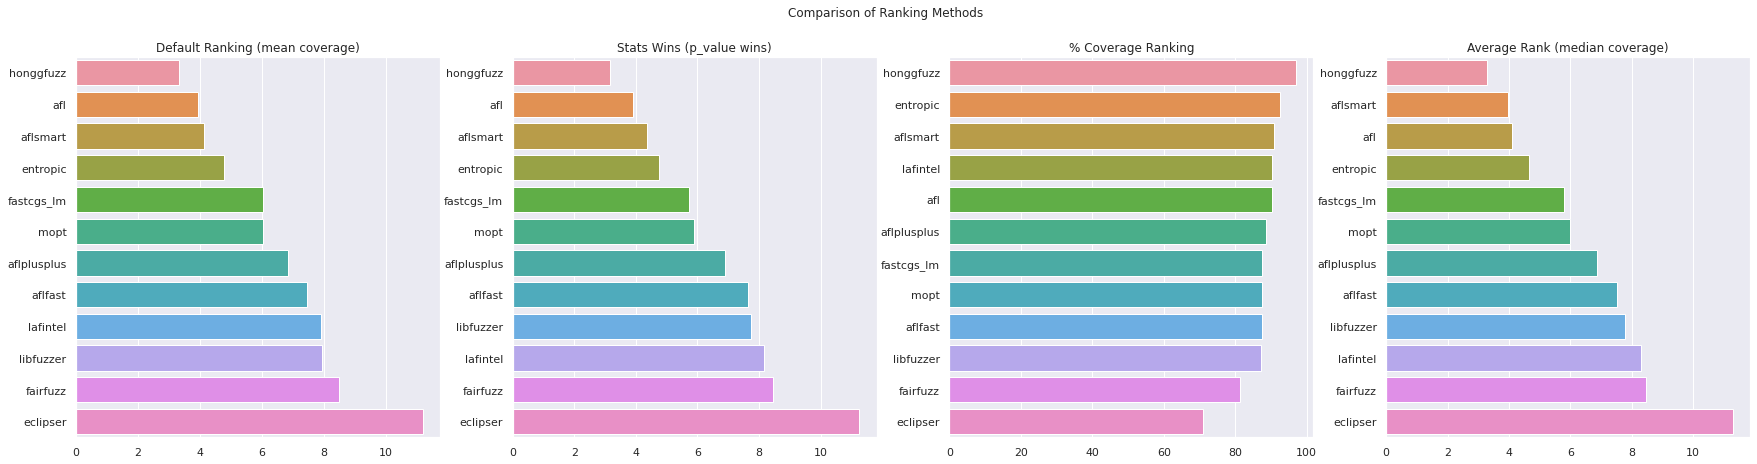

In [17]:
rankings = {
    "Default Ranking (mean coverage)": default_report_rank,
    "Stats Wins (p_value wins)": stats_wins,
    "% Coverage Ranking": percent_coverage,
    "Average Rank (median coverage)": average_rank
}

fig, axes = plt.subplots(1,len(rankings), figsize=(30,7))
for i, (title, ranking_series) in enumerate(rankings.items()):
  ax = sns.barplot(x=ranking_series.values, y=ranking_series.index, ax=axes[i])
  ax.set_title(title)
  ax.set_ylabel("")
fig.suptitle("Comparison of Ranking Methods")
fig.show()